In [1]:
#import some prerequisites

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 10) # Make the figures a bit bigger

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Lambda
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.utils import np_utils

from keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

Using TensorFlow backend.


In [2]:
# Load Data

(X_train, y_train), (X_test, y_test) = mnist.load_data()
(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [3]:
# for tensorflow dimension ordering

X_test = np.expand_dims(X_test, -1)
X_train = np.expand_dims(X_train, -1)

In [4]:
X_train.shape

(60000, 28, 28, 1)

In [5]:
y_train[0:5]

array([5, 0, 4, 1, 9], dtype=uint8)

In [6]:
temp = y_test # for comparisons later

In [7]:
# One hot encoding

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [8]:
mean_px = X_train.mean().astype(np.float32)
std_px = X_train.std().astype(np.float32)

In [9]:
def norm_input(x): 
    return (x-mean_px)/std_px

In [10]:
model = Sequential()

model.add(Lambda(norm_input, input_shape=(28, 28, 1)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization(axis=1))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(BatchNormalization(axis=1))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization(axis=1))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D())

# the model so far outputs 3D feature maps (height, width, features)

model.add(Flatten()) # this converts our 3D feature maps to 1D feature vectors
model.add(BatchNormalization())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

## Data Augmentation

In [12]:
datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08)

batches = datagen.flow(X_train, y_train, batch_size=32)
test_batches = datagen.flow(X_test, y_test, batch_size=32)

In [13]:
model.fit_generator(batches, batches.n, epochs=1,
                    validation_data=test_batches, validation_steps=test_batches.n)

Epoch 1/1
60000/60000 [==============================] - 26598s - loss: 0.0548 - acc: 0.9833 - val_loss: 0.0244 - val_acc: 0.9927


Can furher improve the accuracy by running more epochs and changing the learning rate of the optmizer

In [14]:
score = model.evaluate(X_test, y_test, verbose=0)

print('Test score:', score[0])
print('Test accuracy:', score[1])

('Test score:', 0.014571597389487578)
('Test accuracy:', 0.99570000000000003)


In [15]:
predicted_classes = model.predict_classes(X_test)

10000/10000 [==============================] - 66s    


In [16]:
correct_indices = np.nonzero(predicted_classes == temp)[0]
incorrect_indices = np.nonzero(predicted_classes != temp)[0]

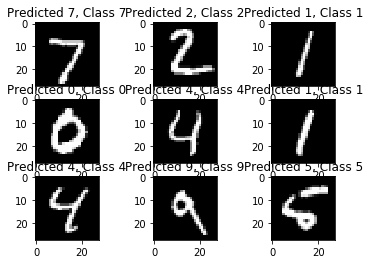

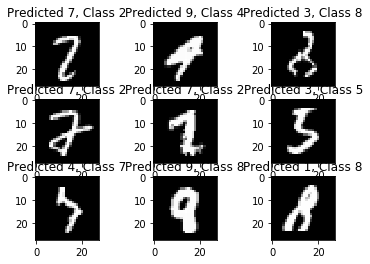

In [18]:
plt.figure()
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], temp[correct]))
    
plt.figure()
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], temp[incorrect]))

In [19]:
model.save('mnist.h5')